In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F

import refsr
import numpy as np

import images as I
import utils as U

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os

from PIL import Image

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.getcwd()
matplotlib.rc("savefig", dpi=100)

In [3]:
is_cuda=True
sr_model = refsr.get_default_sr_model(cuda=is_cuda)
vgg_model = refsr.get_default_vgg_model(cuda=is_cuda)
method = refsr.RefSR(sr_model, vgg_model)

In [4]:
def match_image_and_segmentation(img, segmap):
    assert img.dim() == 3
    assert segmap.dim() == 3

    _, H_img, W_img = img.size()
    _, H_seg, W_seg = segmap.size()

    H, W = min(H_img, H_seg), min(W_img, W_seg)

    return img[:, :H, :W], segmap[:, :H, :W]

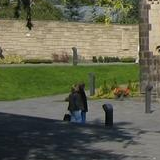

In [5]:
size=160
dx, dy = 600, 75

x_hr_orig=I.load_image("samples/img_001_SRF_8_HR.png")
x_hr_seg_orig=I.torch.load("samples/img_001_SRF_8_HR_bic.pth")
x_hr_orig, x_hr_seg_orig = match_image_and_segmentation(x_hr_orig, x_hr_seg_orig)

x_hr = x_hr_orig[:, dx:dx+size, dy:dy+size]
x_hr_seg = x_hr_seg_orig[:, dx:dx+size, dy:dy+size]

x=I.load_image("samples/img_001_SRF_8_HR.png", resize_scale=0.25)[:, dx//4:(dx+size)//4, dy//4:(dy+size)//4]
x_seg = method.downscale(x_hr_seg.unsqueeze(0)).squeeze(0)

r1=I.load_image("samples/img_047_SRF_8_HR.png")
r1_seg=I.torch.load("samples/img_047_SRF_8_HR_bic.pth")
r1, r1_seg = match_image_and_segmentation(r1, r1_seg)

r2=I.load_image("samples/img_068_SRF_8_HR.png")
r2_seg=I.torch.load("samples/img_068_SRF_8_HR_bic.pth")
r2, r2_seg = match_image_and_segmentation(r2, r2_seg)

# r3=I.load_image("samples/000_3.png")[0]
# r4=I.load_image("samples/000_4.png")[0]
I.to_pil_image(x_hr)[0][0]

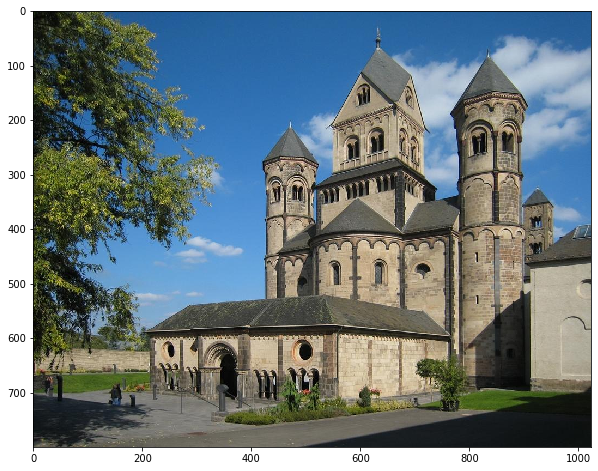

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(I.to_pil_image(x_hr_orig)[0][0])

In [7]:
target_hr = x_hr
input_lr = x
input_lr_seg = x_seg

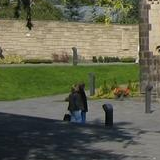

In [8]:
I.to_pil_image(x_hr)[0][0]

In [17]:
def loss(a, b):
    return (a.cuda() - b.cuda()).abs().mean()

def showimg(img):
    if isinstance(img, torch.Tensor):
        img = I.to_pil_image(img)[0][0]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()
def run_ref_seg(t, x, xseg, r, rseg):
    with torch.no_grad():
        if is_cuda:
            y=method.upscale_with_ref_with_seg(
                x=x.cuda(),
                x_seg=xseg.cuda(),
                refs=U.cuda_all(*r),
                refs_seg=U.cuda_all(*rseg),
            )
            torch.cuda.empty_cache()
        else:
            y=method.upscale_with_ref_with_seg(
                x=x,
                x_seg=xseg,
                refs=U.cuda_all(*r),
                refs_seg=U.cuda_all(*rseg),
            )
    
    print("--------------------------")
    print("Input")
    showimg(x)
    for i, rr in enumerate(r):
        print(f"Referece {i}")
        showimg(rr)
    print("Output")
    showimg(y)
    print("Target")
    showimg(t)
    print("Loss", loss(t, y))
    print("--------------------------")
    
    return y
def run_ref(t, x, r):
    with torch.no_grad():
        if is_cuda:
            y=method.upscale_with_ref(
                x=x.cuda(),
                refs=U.cuda_all(*r),
            )
            torch.cuda.empty_cache()
        else:
            y=method.upscale_with_ref(
                x=x,
                refs=U.cuda_all(*r),
            )
            
    print("--------------------------")
    print("Input")
    showimg(x)
    for i, rr in enumerate(r):
        print(f"Referece {i}")
        showimg(rr)
    print("Output")
    showimg(y)
    print("Target")
    showimg(t)
    print("Loss", loss(t, y))
    print("--------------------------")
    return y

patches.size() torch.Size([48260, 256, 3, 3])

Doing classidx 00

Doing layer 1
CondH=40, CondW=40
RH=1, RW=1
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
Subset torch.Size([1452, 256, 3, 3])
PatchSize torch.Size([1452, 256, 3, 3])
NewPatch_H=3, NewPatch_W=3
outputs.size torch.Size([256, 40, 40])
counts.size torch.Size([40, 40])
last_i=37, last_i_start=37, last_i_end=40
last_j=37, last_j_start=37, last_j_end=40
mask.mean() tensor(0.3987, device='cuda:0')
mask.size() torch.Size([1, 1, 40, 40])

Doing layer 2
CondH=40, CondW=40
RH=2, RW=2
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
Subset torch.Size([1452, 128, 6, 6])
PatchSize torch.Size([1452, 128, 6, 6])
NewPatch_H=6, NewPatch_W=6
outputs.size torch.Size([128, 80, 80])
counts.size torch.Size([80, 80])
last_i=37, last_i_start=74, last_i_end=80
last_j=37, last_j_start=74, last_j_end=80
mask.mean() tensor(0.3964, device='cuda:0')
mask.size() torch.Size([1, 1, 80, 80])

Doing layer 3
CondH=40, Cond

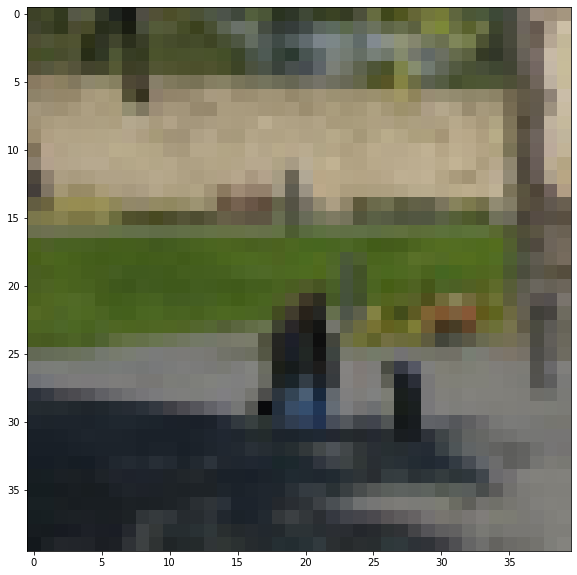

Referece 0


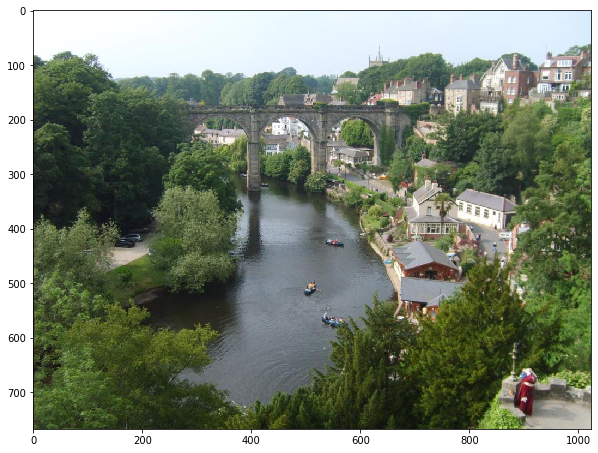

Output


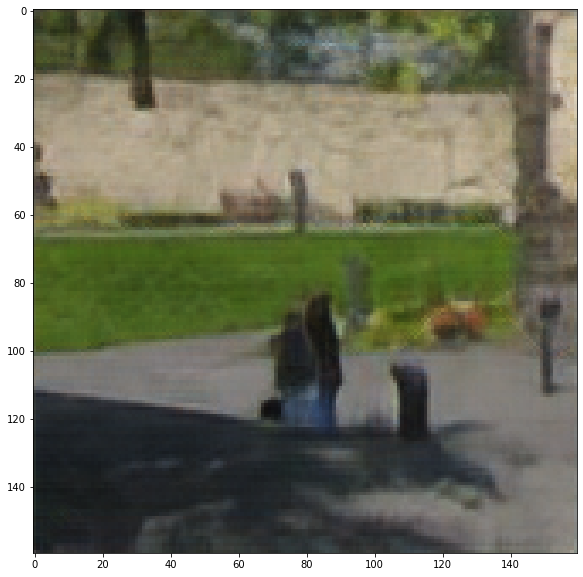

Target


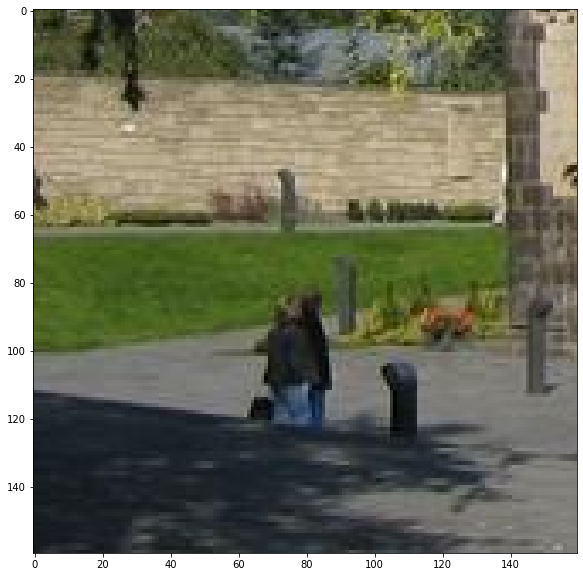

Loss tensor(13.2495, device='cuda:0')
--------------------------


In [20]:
outputs = []
t1 = run_ref_seg(target_hr, input_lr, input_lr_seg, [r2], [r2_seg])
# t2 = run_ref_seg(target_hr, input_lr, input_lr_seg, [r2], [r2_seg])
# t3 = run_ref_seg(target_hr, input_lr, input_lr_seg, [r1, r2], [r1_seg, r2_seg])

CondH=40, CondW=40
RH=1, RW=1
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
PatchSize torch.Size([48260, 256, 3, 3])
NewPatch_H=3, NewPatch_W=3
outputs.size torch.Size([256, 40, 40])
counts.size torch.Size([40, 40])
last_i=37, last_i_start=37, last_i_end=40
last_j=37, last_j_start=37, last_j_end=40
CondH=40, CondW=40
RH=2, RW=2
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
PatchSize torch.Size([48260, 128, 6, 6])
NewPatch_H=6, NewPatch_W=6
outputs.size torch.Size([128, 80, 80])
counts.size torch.Size([80, 80])
last_i=37, last_i_start=74, last_i_end=80
last_j=37, last_j_start=74, last_j_end=80
CondH=40, CondW=40
RH=4, RW=4
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
PatchSize torch.Size([48260, 64, 12, 12])
NewPatch_H=12, NewPatch_W=12
outputs.size torch.Size([64, 160, 160])
counts.size torch.Size([160, 160])
last_i=37, last_i_start=148, last_i_end=160
last_j=37, last_j_start=148, last_j_end=160
--------------------------
Input


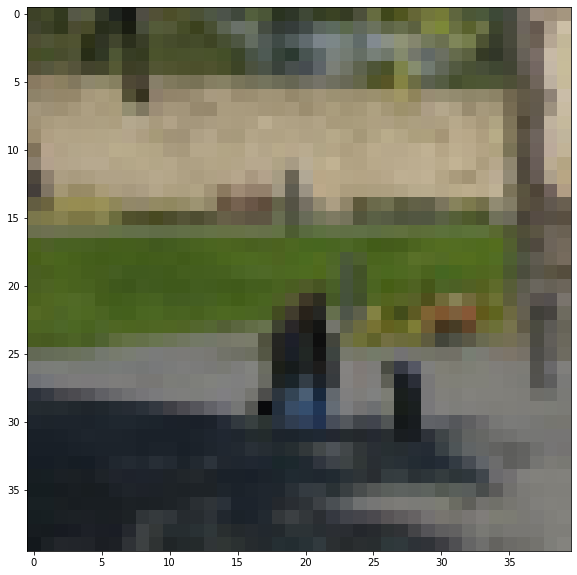

Referece 0


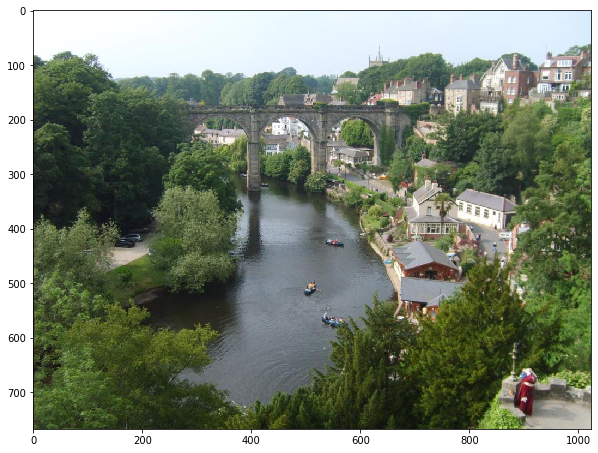

Output


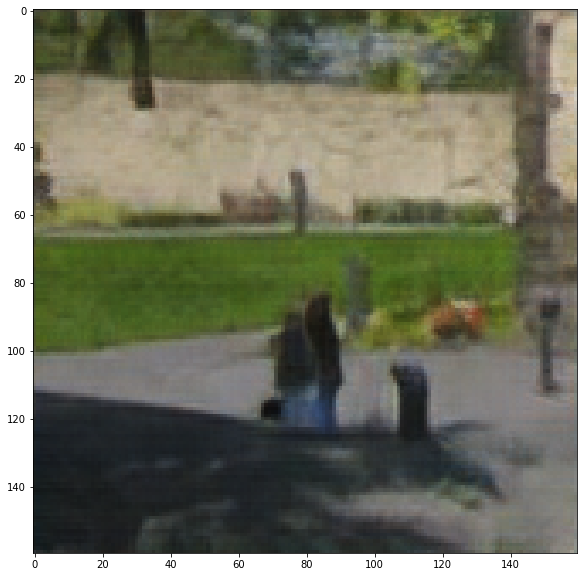

Target


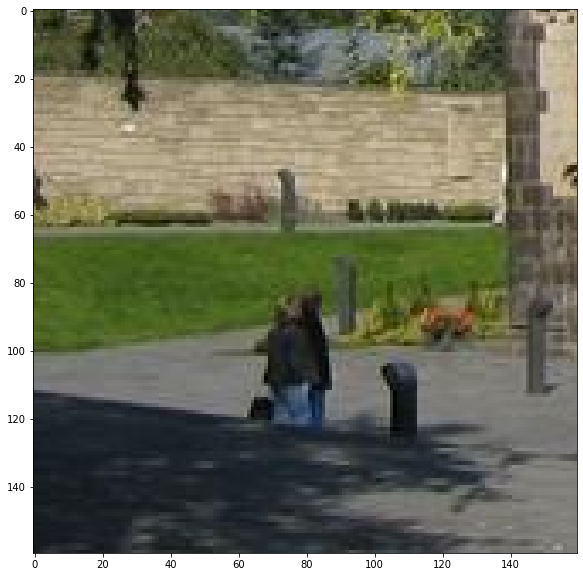

Loss tensor(13.3962, device='cuda:0')
--------------------------


In [21]:
t2 = run_ref(target_hr, input_lr, [r2])